In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pathlib
from scipy.linalg import lstsq
from qutip import *

In [3]:
def ising_hamiltonian(n_spins,h):

  si = qeye(2)
  sx = sigmax()
  sy = sigmay()
  sz = sigmaz()

  sx_list = []
  sy_list = []
  sz_list = []

  for n in range(n_spins):
      op_list = []
      for m in range(n_spins):
          op_list.append(si)

      op_list[n] = sx
      sx_list.append(tensor(op_list))

      op_list[n] = sy
      sy_list.append(tensor(op_list))

      op_list[n] = sz
      sz_list.append(tensor(op_list))

  #Hamiltonian

  H = 0

  #Transverse field

  for n in range(n_spins):
    H += - h* sz_list[n]

  #Interaction terms

  # Random interaction matrix
  np.random.seed(2)
  J_ij = -np.random.uniform(0, 1, size=(n_spins, n_spins))
  J_ij = (J_ij + J_ij.T) / 2  # Ensure symmetric matrix

  for n in range(n_spins):
    for m in range(n+1,n_spins):
      H += J_ij[n,m]*sx_list[n]*sx_list[m]

  return H

In [4]:
def initial_state(n_spins): #Random initial state (always the same)

  iter = rand_dm(2, seed=3)

  for i in range(1,n_spins):

    iter = tensor(iter,rand_dm(2, seed=2))

  return iter



def insert_input(input_state, reservoir): #Insert a two qubit entangled state into the reservoir (Werner)

  n_spins = len(reservoir.dims[0])
  reduced = reservoir.ptrace([i for i in range(2,n_spins)])

  return tensor(input_state,reduced)

In [5]:
initial_state(6).isherm

True

In [6]:
#Measure z observable over all the qubits except the first two
#medimos con sz_list

def expectation_sxyz(rho): #measure sz exp value over all spins
  n_spins = len(rho.dims[0])

  si = qeye(2)
  sx = sigmax()
  sy = sigmay()
  sz = sigmaz()

  sx_list = []
  sy_list = []
  sz_list = []

  for n in range(n_spins):
      op_list = []
      for m in range(n_spins):
          op_list.append(si)

      op_list[n] = sx
      sx_list.append(tensor(op_list))

      op_list[n] = sy
      sy_list.append(tensor(op_list))

      op_list[n] = sz
      sz_list.append(tensor(op_list))

  #Correlations

  corr_list = []
    
  for n in range(n_spins):
      op_list = []
      for m in range(n_spins):
          op_list.append(si)

      if n != n_spins-1:
          op_list[n] = sx
          op_list[n+1] = sy
          
      else:
          op_list[n] = sx
          op_list[0] = sy

      corr_list.append(tensor(op_list))
        
      #print(corr_list)

  exp = []
  for i in range(n_spins): #range(2,n_spins)
    exp.append(expect(rho,sx_list[i]))
    exp.append(expect(rho,sy_list[i]))
    exp.append(expect(rho,sz_list[i]))
    exp.append(expect(rho,corr_list[i]))

  return exp

In [7]:
 expectation_sxyz(initial_state(3))

[-0.13937538539784924,
 -0.36467180232549634,
 0.43701362128534427,
 -0.001024167597289443,
 -0.34424885624077867,
 0.0073482673742277325,
 0.10156841474587337,
 -0.0025296326389293283,
 -0.34424885624077867,
 0.007348267374227733,
 0.10156841474587337,
 0.12553785085381547]

In [8]:
def input_state_cross(p,c1,c2):
     
  q = 1/2 - p
    
  if c1 > abs(p) or c2 > abs(q):
      raise Exception("Not physical")
      
  ap = basis(2,0)
  bp = basis(2,1)

  a1 = tensor(ap,bp)
  b1 = tensor(bp,ap)
  a2 = tensor(ap,ap)
  b2 = tensor(bp,bp)

  f1 = a1*a1.dag() + b1*b1.dag()
  f2 = a2*a2.dag() + b2*b2.dag()
  f3 = a2*b2.dag() + b2*a2.dag()
  f4 = a1*b1.dag() + b1*a1.dag()

  rho = p*f2+ q*f1+ c1*f3 + c2*f4

  return rho

In [9]:
def input_state_cross_complex(p,q,r,c1,c2):
             
  s = 1 - p - q - r
    
  if c1 > np.sqrt(abs(p*s)) or c2 > np.sqrt(abs(q*r)):
      raise Exception("Not physical")
      
  ap = basis(2,0)
  bp = basis(2,1)

  a1 = tensor(ap,bp)
  b1 = tensor(bp,ap)
  a2 = tensor(ap,ap)
  b2 = tensor(bp,bp)

  f1 = a1*a1.dag()
  f2 = a2*a2.dag()
  f3 = b1*b1.dag()
  f4 = b2*b2.dag()
  f5 = a2*b2.dag() + b2*a2.dag()
  f6 = a1*b1.dag() + b1*a1.dag()

  rho = p*f2+ q*f1+ r*f3 + s*f4 + c1*f5 + c2*f6

  return rho

In [10]:
input_state_cross_complex(1/7,2/7,3/7,1/10,1/10)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.14285714 0.         0.         0.1       ]
 [0.         0.28571429 0.1        0.        ]
 [0.         0.1        0.42857143 0.        ]
 [0.1        0.         0.         0.14285714]]

In [11]:
input_state_cross(1/3,1/8,1/8)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.33333333 0.         0.         0.125     ]
 [0.         0.16666667 0.125      0.        ]
 [0.         0.125      0.16666667 0.        ]
 [0.125      0.         0.         0.33333333]]

In [12]:
#Function with two qubit state as imput and output of the evolved reservoir

def QRC(state,n_spins):

  h=-1
  H = ising_hamiltonian(n_spins,h)
  
  rho = initial_state(n_spins)

  for i in range(4):
      reservoir_inserted = insert_input(state, rho)
      
      #Evolve state
      time = 3
      time_list = [i for i in range(time)]

      rho = mesolve(H, reservoir_inserted, time_list).states[-1]

  #Measure sx, sy, sz exp values
  exp = expectation_sxyz(rho)
  exp = np.real(np.round(exp,5))

  #Linear combination with optimization parameters
  return exp.tolist()

In [13]:
#Training
total = 200
train_time = int(0.8*total)
test_time = total-train_time
np.random.seed(54)

states = []
conc = []
conc_int = []

#Generate random states for the input state
for i in range(total):
    
    p = np.random.uniform(0,1) #p entre -1 y 1 va bien para concurrence, 0 y 1 para negativity
    #p = np.random.uniform(0,1)
    #q = 1/2-p
    q = np.random.uniform(0,1)
    r = np.random.uniform(0,1)
    s = 1-p-q-r
    
    #c1 = np.random.uniform(-abs(p), abs(p))
    #c2 = np.random.uniform(-abs(q), abs(q))

    c1 = np.random.uniform(-np.sqrt(abs(p*s)), np.sqrt(abs(p*s)))
    c2 = np.random.uniform(-np.sqrt(abs(q*r)), np.sqrt(abs(q*r)))

    #state = input_state_cross(p,c1,c2)
    state = input_state_cross_complex(p,q,r,c1,c2)
    states.append(state)
    #concurr = np.round(concurrence(state),3)
    concurr = np.round(negativity(state,[0,1]),3)
    #print(concurr)
    
    if concurr != 0:
        concurr = [0,1] #entangled
        conc_int.append(1)
    else:
        concurr = [1,0] #not entangled
        conc_int.append(0)
        
    conc.append(concurr)


train = states[:train_time]
conc_train = conc[:train_time]
conc_train_int = conc_int[:train_time]

test = states[train_time:]
conc_test = conc[train_time:]
conc_test_int = conc_int[train_time:]




# Getting optimal weights
n_spins = 6

output = np.zeros([train_time, 4*n_spins+1])
for i in range(train_time):
  output[i,:] = (QRC(train[i],n_spins))+[1]

opt_weights, _, _, _ = lstsq(output,conc_train) # n_spins weights + 1 (término independiente)
train_predicted = np.matmul(output,opt_weights)

output_test = np.zeros([test_time, 4*n_spins+1])

for i in range(test_time):
  output_test[i,:] = (QRC(test[i],n_spins)) + [1]


predicted = np.matmul(output_test,opt_weights)

In [14]:
predicted_binary = []
for i in range(len(predicted)):
    if predicted[i][0] > predicted[i][1]: 
        predicted_binary.append(0) #not entangled
    else:
        predicted_binary.append(1) #entangled

0.053566173462635015


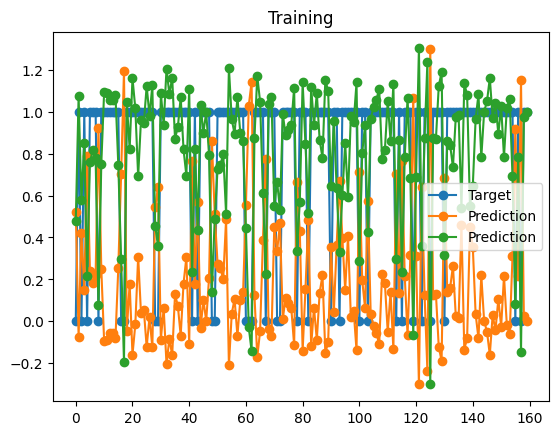

In [15]:
plt.title('Training')
plt.plot(np.arange(train_time), conc_train_int, marker='o', label= 'Target')
plt.plot(np.arange(train_time), train_predicted, marker='o', label = 'Prediction')
plt.legend()

mse_train = np.mean((train_predicted - conc_train) ** 2)
print(mse_train)

0.06214917830255016


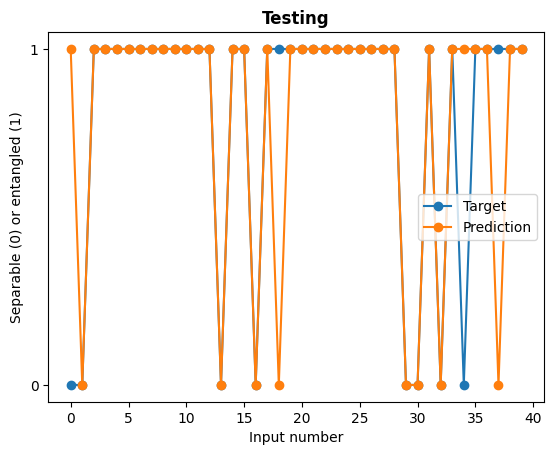

In [16]:
plt.title('Testing', fontweight="bold")
plt.plot(np.arange(test_time), conc_test_int, marker='o', label = 'Target')
plt.plot(np.arange(test_time), predicted_binary, marker='o', label = 'Prediction')
plt.yticks([0, 1])
plt.legend()
plt.xlabel('Input number')

plt.ylabel('Separable (0) or entangled (1)')

mse_test = np.mean((predicted - conc_test) ** 2)
print(mse_test)

5.0


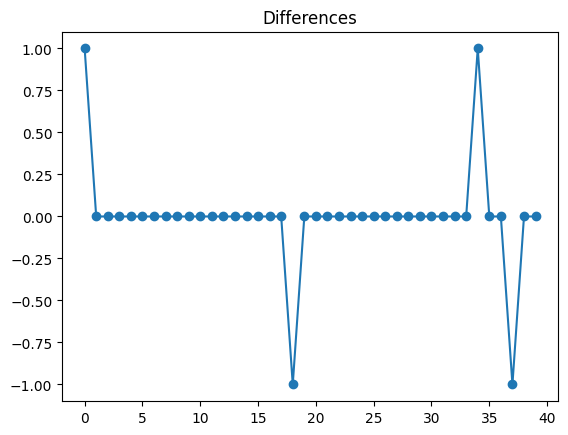

In [17]:
diff = np.array(predicted_binary)-np.array(conc_test_int)
plt.plot(np.arange(test_time),diff, marker='o', label = 'Prediction')
plt.title('Differences')
errors = np.cumsum(diff == 1)[-1]
relative = errors/test_time * 100

print(relative)

In [18]:
#mismo n de inputs, 3 tiempos distintos!
#Probar negativity
#Promediar estadística.

In [19]:
def QRC(state,n_spins,n_injections):

  h=-1
  H = ising_hamiltonian(n_spins,h)
  
  rho = initial_state(n_spins)

  for i in range(n_injections):
      reservoir_inserted = insert_input(state, rho)
      
      #Evolve state
      time = 3
      time_list = [i for i in range(time)]

      rho = mesolve(H, reservoir_inserted, time_list).states[-1]

  #Measure sx, sy, sz exp values
  exp = expectation_sxyz(rho)
  exp = np.real(np.round(exp,5))

  #Linear combination with optimization parameters
  return exp.tolist()

In [20]:
def statistics(random_number, n_injections):
    
    #Training
    np.random.seed(random_number)
    
    total = 200
    train_time = int(0.8*total)
    test_time = total-train_time
    
    states = []
    conc = []
    
    
    #Generate random states for the input state
    for i in range(total):
        
        p = np.random.uniform(0,1) #p entre -1 y 1 va bien para concurrence, 0 y 1 para negativity
        #p = np.random.uniform(0,1)
        q = 1/2-p
        #q = np.random.uniform(0,1)
        #r = np.random.uniform(0,1)
        #s = 1-p-q-r
        
        c1 = np.random.uniform(-abs(p), abs(p))
        c2 = np.random.uniform(-abs(q), abs(q))
    
        #c1 = np.random.uniform(-np.sqrt(abs(p*s)), np.sqrt(abs(p*s)))
        #c2 = np.random.uniform(-np.sqrt(abs(q*r)), np.sqrt(abs(q*r)))
    
        state = input_state_cross(p,c1,c2)
        #state = input_state_cross_complex(p,q,r,c1,c2)
        states.append(state)
        #concurr = np.round(concurrence(state),3)
        concurr = np.round(negativity(state,[0,1]),3)
        #print(concurr)
            
        conc.append(concurr)
    
    
    train = states[:train_time]
    conc_train = conc[:train_time]
    
    
    test = states[train_time:]
    conc_test = conc[train_time:]
    
    
    # Getting optimal weights
    n_spins = 6
    
    output = np.zeros([train_time, 4*n_spins+1])
    for i in range(train_time):
      output[i,:] = (QRC(train[i],n_spins,n_injections))+[1]
    
    opt_weights, _, _, _ = lstsq(output,conc_train) # n_spins weights + 1 (término independiente)
    train_predicted = np.matmul(output,opt_weights)
    
    output_test = np.zeros([test_time, 4*n_spins+1])
    
    for i in range(test_time):
      output_test[i,:] = (QRC(test[i],n_spins,n_injections)) + [1]
    
    
    predicted = np.matmul(output_test,opt_weights)
    
    #mse_train = np.mean((train_predicted - conc_train) ** 2)
    
    mse_test = np.mean((predicted - conc_test) ** 2)
    print(mse_test)
    
    return mse_test

In [21]:
average_inj = []
std = []

for n in range(1,6):
    promedio = []
    for i in range(1,5):
        promedio.append(statistics(i, n))
    
    average_mse = np.cumsum(promedio)[-1]/len(promedio)
    std_dev = np.std(promedio)
    average_inj.append(average_mse)
    std.append(std_dev)

0.02835860729940855
0.016991977575512778
0.02112412687975355
0.032723325840192094
0.0020569061881299984
0.0010793772533642602
0.0021343929049791022
0.001488869941013745
0.0018334758951191413
0.0020397415758807522
0.002237142203781764
0.001952984614912928
0.0011722495570400115
0.0014134907115111585
0.0010690871870663657
0.0013701178535286602
0.002438898662508559
0.004766213585519095
0.002107919504035985
0.0022427550208071892


In [22]:
average_inj

[np.float64(0.024799509398716744),
 np.float64(0.0016898865718717763),
 np.float64(0.0020158360724236465),
 np.float64(0.001256236327286549),
 np.float64(0.002888946693217707)]

Text(0.5, 1.0, 'Evolution of error with number of input injections')

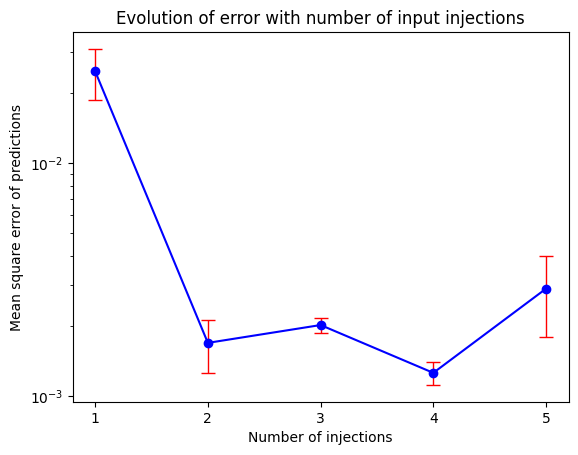

In [36]:
plt.errorbar(np.arange(1,6), average_inj, yerr=std, fmt='o', color='blue', ecolor='red', capsize=5, capthick=1, elinewidth=1)
plt.plot(np.arange(1,6), average_inj, color='blue')
plt.xlabel('Number of injections')
plt.ylabel('Mean square error of predictions')
plt.yscale('log')
plt.xticks(ticks=[1,2,3,4,5])
plt.title('Evolution of error with number of input injections')

0.008693344889289752


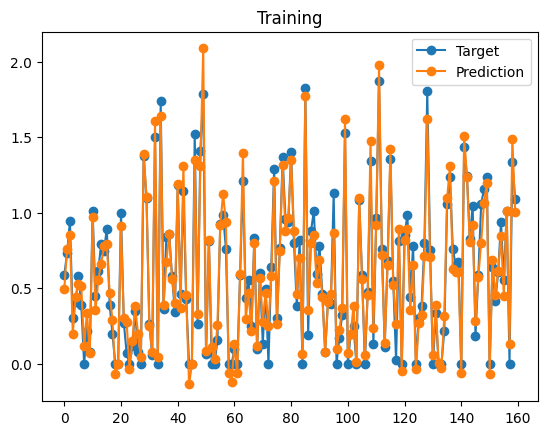

In [28]:
plt.title('Training')
plt.plot(np.arange(train_time), conc_train, marker='o', label= 'Target')
plt.plot(np.arange(train_time), train_predicted, marker='o', label = 'Prediction')
plt.legend()

mse_train = np.mean((train_predicted - conc_train) ** 2)
print(mse_train)

0.0206936577522386


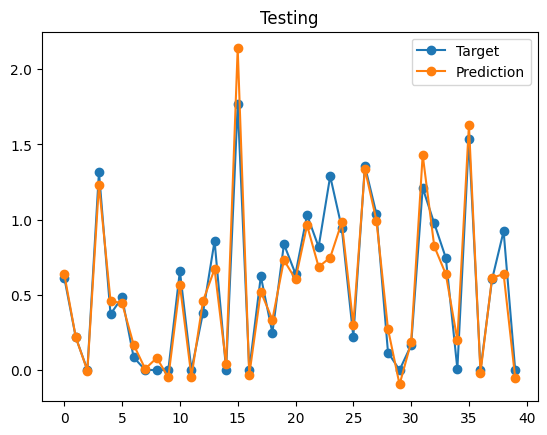

In [29]:
plt.title('Testing')
plt.plot(np.arange(test_time), conc_test, marker='o', label = 'Target')
plt.plot(np.arange(test_time), predicted, marker='o', label = 'Prediction')
plt.legend()

mse_test = np.mean((predicted - conc_test) ** 2)
print(mse_test)

In [32]:
def statistics_binary(random_number, n_injections):
    
    #Training
    np.random.seed(random_number)
    
    total = 200
    train_time = int(0.8*total)
    test_time = total-train_time
    #np.random.seed(54)
    
    states = []
    conc = []
    conc_int = []
    
    #Generate random states for the input state
    for i in range(total):
        
        p = np.random.uniform(0,1) #p entre -1 y 1 va bien para concurrence, 0 y 1 para negativity
        #p = np.random.uniform(0,1)
        q = 1/2-p
        #q = np.random.uniform(0,1)
        #r = np.random.uniform(0,1)
        #s = 1-p-q-r
        
        c1 = np.random.uniform(-abs(p), abs(p))
        c2 = np.random.uniform(-abs(q), abs(q))
    
        #c1 = np.random.uniform(-np.sqrt(abs(p*s)), np.sqrt(abs(p*s)))
        #c2 = np.random.uniform(-np.sqrt(abs(q*r)), np.sqrt(abs(q*r)))
    
        state = input_state_cross(p,c1,c2)
        #state = input_state_cross_complex(p,q,r,c1,c2)
        states.append(state)
        #concurr = np.round(concurrence(state),3)
        concurr = np.round(negativity(state,[0,1]),3)
        #print(concurr)
        
        if concurr != 0:
            concurr = [0,1] #entangled
            conc_int.append(1)
        else:
            concurr = [1,0] #not entangled
            conc_int.append(0)
            
        conc.append(concurr)
    
    
    train = states[:train_time]
    conc_train = conc[:train_time]
    conc_train_int = conc_int[:train_time]
    
    test = states[train_time:]
    conc_test = conc[train_time:]
    conc_test_int = conc_int[train_time:]
    
    
    # Getting optimal weights
    n_spins = 6
    
    output = np.zeros([train_time, 4*n_spins+1])
    for i in range(train_time):
      output[i,:] = (QRC(train[i],n_spins, n_injections))+[1]
    
    opt_weights, _, _, _ = lstsq(output,conc_train) # n_spins weights + 1 (término independiente)
    train_predicted = np.matmul(output,opt_weights)
    
    output_test = np.zeros([test_time, 4*n_spins+1])
    
    for i in range(test_time):
      output_test[i,:] = (QRC(test[i],n_spins,  n_injections)) + [1]
    
    
    predicted = np.matmul(output_test,opt_weights)

    predicted_binary = []
    for i in range(len(predicted)):
        if predicted[i][0] > predicted[i][1]: 
            predicted_binary.append(0) #not entangled
        else:
            predicted_binary.append(1) #entangled

    
    n_errors = np.cumsum(np.abs((np.array(predicted_binary) - np.array(conc_test_int))))[-1]
    
    return n_errors

In [34]:
statistics_binary(2, 2)

np.int64(3)

In [35]:
average_inj_binary = []

for n in range(1,6):
    promedio = []
    for i in range(1,5):
        promedio.append(statistics_binary(i, n))
    
    average_mse = np.cumsum(promedio)[-1]/len(promedio)
    average_inj_binary.append(average_mse)

Text(0.5, 1.0, 'Evolution of error with number of input injections')

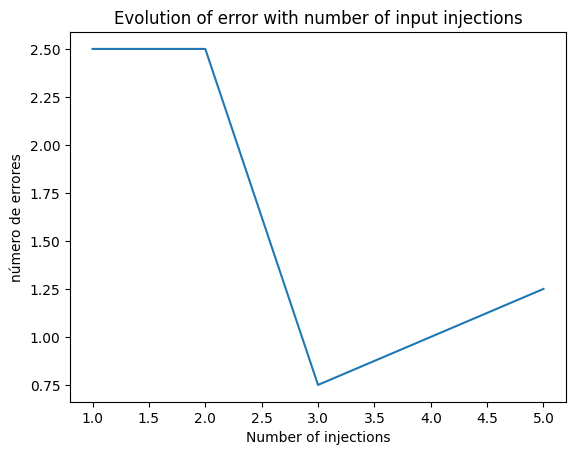

In [38]:
plt.plot(np.arange(1,6), average_inj_binary)
plt.xlabel('Number of injections')
plt.ylabel('número de errores')
#plt.yscale('log')
plt.title('Evolution of error with number of input injections')

In [ ]:
#meter desviacion